In [1]:
import os
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import stats
from sklearn.utils import resample
from collections import OrderedDict, Counter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.utils.data.dataset import Dataset

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models 

In [2]:
#Transforms
testing_transforms = transforms.Compose([transforms.ToPILImage(),
                                         transforms.Resize((120, 160)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

In [3]:
#Get testing data 
data_dir = "../ISL-master/Frames/"
test_files = sorted(glob.glob(os.path.join(data_dir, "Person5*")) + glob.glob(os.path.join(data_dir, "Person6*")))

#Get labels
test_labels = [file_name.split('-')[-3] for file_name in test_files]

#Get list of classes 
classes = list(Counter(test_labels).keys())

#Dict for class indices
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

print("Test size: {} frames.".format(len(test_files)))

Test size: 20408 frames.


In [4]:
#Defining dataset class
class ISLHandsignDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        """
        image_paths (str): Path to image file. 
        """
        
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = self.transform(image)
        
        label = self.labels[idx]
        label = class_to_idx[label]
        
        return image, label

In [5]:
#Loading dataset and defining dataloader
testing_dataset = ISLHandsignDataset(test_files, test_labels, transform=testing_transforms)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

In [6]:
#Check if a GPU is available and if not use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
#Loading the model trained on rgb frames
loaded_model = torch.load('../trained_models/method02.pth')

In [8]:
#Testing the model: 

def test(model, test_loader):
    
    model.eval()
    model.to(device)
    
    probs = []
    targets = []
    
    with torch.no_grad():
                
        for images, labels in iter(test_loader):
                        
            images, lables = images.to(device), labels.to(device)
            
            target = labels.clone()
            
            output = model.forward(images)
            
            probs.append(torch.exp(output).cpu().numpy())
            targets.append(target.cpu().numpy())
            
    probs = np.argmax(np.concatenate(probs), axis=1)
    targets = np.concatenate(targets)
    
    return targets, probs
        
y_true, y_pred = test(loaded_model, test_loader)

In [9]:
# From training logs: 
# Epoch: 50/50:  Training Loss: 0.001  Training Accuracy: 1.000  Validation Loss: 9.079  Validation Accuracy: 0.432

print("Test Accuracy : {:.3f}%".format(accuracy_score(y_true, y_pred)*100))
print("F1 Score : {:.3f}".format(f1_score(y_true, y_pred, average='micro')))

Test Accuracy : 43.346%
F1 Score : 0.433


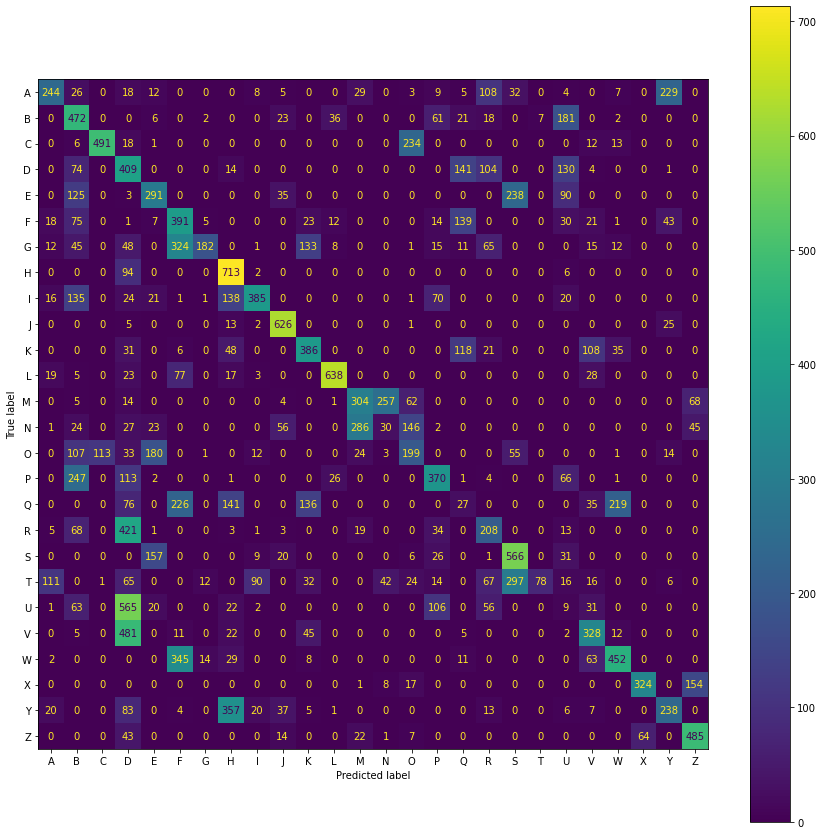

In [10]:
#Create confusion matrix
cf = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=classes)

#Dispay and save fig
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.savefig('../ConfusionMatrices/cf02.png')
plt.show()

In [11]:
# Slightly adapted from here: 
# https://machinelearningmastery.com/confidence-intervals-for-machine-learning/

accuracy = accuracy_score(y_true, y_pred)

# 95% confidence 
z = 1.96

# Number of examples (sample size of the test set)
n = len(y_true)

# 95% confidence interval
interval = z * np.sqrt( (accuracy * (1 - accuracy)) / n)

# Note the interval is huge for this example as we have very few values for n!! 
print("Accuracy:{} +- {} ".format(accuracy, interval))

Accuracy:0.4334574676597413 +- 0.006799004881568958 


In [12]:
# Number of bootstraps to do.
num_boot = 1000

# List to collect sample scores.
resampled_scores = []
for _ in range(num_boot):
    # Resample labels and predictions with replacement.
    y_true_re, y_pred_re = resample(y_true, y_pred, replace=True)
    
    # Calculate f1 score with for the resampled labels and predictions. 
    # Use macro averaging.
    f1 = f1_score(y_true_re, y_pred_re, average='macro')
    
    # Add this score to our sample scores list. 
    resampled_scores.append(f1)

# Calculate 95% confidence intervals. 
ci = stats.norm.interval(alpha=0.95, loc=np.mean(resampled_scores), scale=stats.sem(resampled_scores))
print("lower: {}, Upper: {}".format(ci[0], ci[1]))

lower: 0.4326957604280813, Upper: 0.43306513013395415
